In [1]:
# Feature Indentification
# Dataset = https://drive.google.com/file/d/1KA7Vk2utVF8c0u0n31usvhqOXoY9jGd4/view?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from __future__ import division
from datetime import datetime, timedelta,date
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import os
import xgboost as xgb

In [2]:
# Reading the data
PATH = r"C:\Users\aryan\OneDrive\Desktop\DA Projects\AIML\Project_2\customer_segmentation.csv"

# Load data
if os.path.exists(PATH):
    data_df = pd.read_csv(PATH,encoding='cp1252')
    print("Data loaded successfully.")
else:
    print("File not found.")

Data loaded successfully.


In [3]:
# Initiating plotly
pyoff.init_notebook_mode

data_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
#converting the type of Invoice Date Field from string to datetime.
data_df['InvoiceDate'] = pd.to_datetime(data_df['InvoiceDate'])

In [5]:
# Creating YearMonth field for the ease of reporting and visualization
data_df['InvoiceYearMonth'] = data_df['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [6]:
data_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,201099.713989
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,201012.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,201103.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,201107.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,201110.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,201112.000000
std,218.081158,NaN,96.759853,1713.600303,25.788703


In [7]:
data_df['Country'].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [8]:
# using the UK data only here
uk_data = data_df.query("Country == 'United Kingdom'").reset_index(drop=True)

In [9]:
# Segmentation Techniques

# You can do many different segmentations according to what you are trying to achieve. If you want to increase retention rate, you can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now we are going to implement one of them to our business: RFM. RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

# Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
# Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
# High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.
# As the methodology, we need to calculate Recency, Frequency and Monetary Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each. Let’s jump into coding and see how to do RFM Clustering.

In [10]:
#  RECENCY
# To calculate recency, we need to find out most recent purchase date of each customer and 
# see how many days they are inactive for.
# After having no. of inactive days for each customer, 
# we will apply K-means* clustering to assign customers a recency score.

In [11]:
# Generic user df to keep CustID and new Sefmentation Scores
user_df = pd.DataFrame(data_df['CustomerID'].unique())
user_df.columns = ['CustomerID']
user_df.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [12]:
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [13]:
# Since we are calculating recency, we need to know when last the person bought something. Let us calculate the last date of transaction for a person.
data_max_purchase = uk_data.groupby('CustomerID').InvoiceDate.max().reset_index()
data_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
data_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [14]:
# Recency = Compare the last transaction of the dataset with last transaction dates of the individual customer IDs
data_max_purchase['Recency'] = (data_max_purchase['MaxPurchaseDate'].max() - data_max_purchase['MaxPurchaseDate']).dt.days
data_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [15]:
user_df = pd.merge(user_df, data_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
user_df.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [16]:
# user_df = user_df.drop(['Recency_x', 'Recency_y'], axis=1)
user_df.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


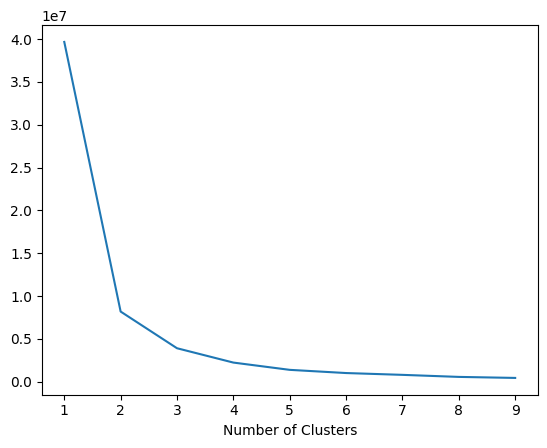

In [20]:
# Assigning a recency score using K-means
# using the Elbow method to find th enumber of optimal clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
sse={}
data_recency = user_df[['Recency']]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,max_iter=1000).fit(data_recency)
    data_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of Clusters")
plt.show()


In [21]:
# Understanding the Elbow Plot:

# The x-axis represents the number of clusters (k) tested (1 to 9 in your code).

# The y-axis represents the Inertia (SSE) value for each number of clusters.

# Ideally, the graph should show a distinctive "elbow" shape. This indicates a point where the rate of decrease in Inertia starts to slow down significantly.

# The number of clusters corresponding to the "elbow" is considered the optimal choice as it represents a good balance between maximizing cluster tightness (lower Inertia) and avoiding overfitting (too many clusters).

In [22]:
# Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 for this example

In [23]:
# 4 Clusters
kmeans = KMeans(n_clusters=4)
user_df['RecencyCluster'] = kmeans.fit_predict(user_df[['Recency']])

In [24]:
user_df.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,2
1,13047.0,31,0
2,13748.0,95,3
3,15100.0,329,2
4,15291.0,25,0


In [25]:
user_df.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
3,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0


In [26]:
# Putting the Clusters in Order
# We have a cluster corresponding to each customerID. But each cluster is randomly assigned. 
# Cluster 2 is not better than cluster 1 for e.g. and so on.
#  We want to give clusters according to most recent transactions.

# We will first find the mean of recency value corresponding to each cluster.
#  Then we will sort these values.
#  Let's say cluster 3 has the most recent transactions mean value. 
# From the above table we see that cluster 1(mean recency 304) > cluster 2 > cluster 3 > cluster 0. 
# That means that cluster 1 is most inactive and cluster 0 is most recent.
#  We will give indices to these clusters as 0,1,2,3.
#  So cluster 1 becomes cluster 0, cluster 2 becomes cluster 1, cluster 3 becomes cluster 2 and so on.
#  Now we will drop the original cluster numbers and replace them with 0,1,2,3. 

In [27]:
def order_cluster(cluster_field_name,target_field_name,df,ascending):
    new_cluster_feild_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']],on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
user_df = order_cluster('RecencyCluster','Recency',user_df,False)

In [28]:
user_df.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,13047.0,31,3
2,13748.0,95,2
3,15100.0,329,0
4,15291.0,25,3


In [29]:
# Now clusters are arrnaged due to inactivity 0->3

In [30]:
# Frequqncy Clusters
# To create frequency clusters, we need to find total number orders for each customer.

In [31]:
# Order Counts for each user and creating DF with it 
data_freq = uk_data.groupby('CustomerID').InvoiceDate.count().reset_index()
data_freq.columns = ['CustomerID', 'Frequency']

In [32]:
data_freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [33]:
user_df = pd.merge(user_df,data_freq,on='CustomerID')
print(user_df.head())

   CustomerID  Recency  RecencyCluster  Frequency
0     17850.0      301               0        312
1     13047.0       31               3        196
2     13748.0       95               2         28
3     15100.0      329               0          6
4     15291.0       25               3        109


C:\Users\aryan\AppData\Local\Temp\ipykernel_11308\3516976932.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aryan\AppData\Local\Temp\ipykernel_11308\3516976932.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aryan\AppData\Local\Temp\ipykernel_11308\3516976932.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

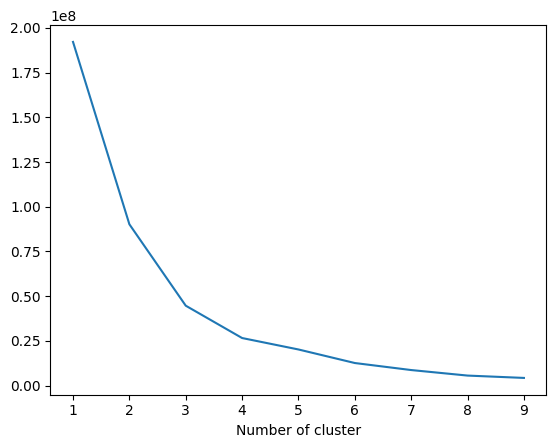

In [34]:
# Elbow method for finding number of clusters

sse={} # error
data_recency = user_df[['Frequency']]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,max_iter=1000).fit(data_recency)
    data_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
# Clusters = 4
kmeans = KMeans(n_clusters=4)
user_df['FrequencyCluster'] = kmeans.fit_predict(user_df[['Frequency']])

user_df = order_cluster('FrequencyCluster','Frequency',user_df,True)
user_df.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3647.0,56.430491,55.249115,1.0,15.00,35.0,82.00,249.0
1,298.0,446.476510,243.368106,252.0,297.00,363.5,500.75,1857.0
2,4.0,3760.750000,1318.609210,2491.0,2709.25,3712.0,4763.50,5128.0
3,1.0,7983.000000,NaN,7983.0,7983.00,7983.0,7983.00,7983.0


In [36]:
# Cluster with max frequency is cluster 3, least frequency cluster is cluster 0.

In [37]:
# --------------------------------- REVENUE ---------------------------------
# Clustering basis on revenue
uk_data['Revenue'] = uk_data['UnitPrice']*uk_data['Quantity']
data_revenue = uk_data.groupby('CustomerID').Revenue.sum().reset_index()

In [38]:
data_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [39]:
user_df = pd.merge(user_df,data_revenue,on='CustomerID')
print(user_df.head())

   CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue
0     17850.0      301               0        312                 1  5288.63
1     13047.0       31               3        196                 0  3079.10
2     13748.0       95               2         28                 0   948.25
3     15100.0      329               0          6                 0   635.10
4     15291.0       25               3        109                 0  4596.51


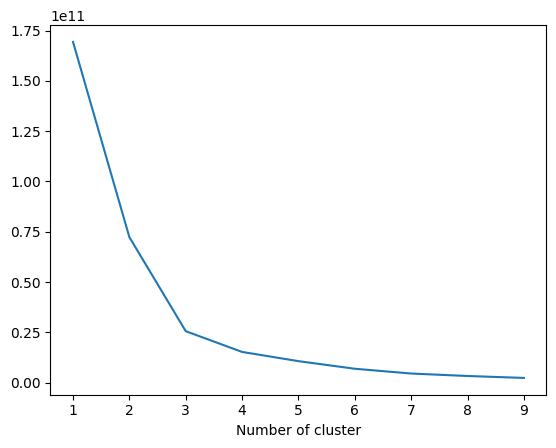

In [41]:
# Elbow method to find out the optimum number of clusters for K-Means
from sklearn.cluster import KMeans

sse={} # error
data_recency = user_df[["Revenue"]]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(data_recency)
    sse[k] = kmeans.inertia_  # Inertia is the sum of squared distances

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [42]:
kmeans = KMeans(n_clusters=4)
user_df['RevenueCluster'] = kmeans.fit_predict(user_df[['Revenue']])
user_df = order_cluster('RevenueCluster','Revenue',user_df,True)
user_df.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3757.0,980.570478,1057.795016,-4287.63,267.1300,589.44,1317.620,5367.80
1,172.0,9862.215872,5307.338111,5423.15,6376.4225,7821.64,10952.760,29072.10
2,19.0,49665.701053,14544.232148,31300.08,35078.5550,50992.61,57253.395,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.2500,221960.33,239199.410,256438.49


In [43]:
# Overall Score based on RFM Clustering
user_df['OverallScore'] = user_df['RecencyCluster'] + user_df['FrequencyCluster'] + user_df['RevenueCluster']

# Calculate mean of RFM components for each OverallScore
user_df.groupby('OverallScore')[['Recency', 'Frequency', "Revenue"]].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.481092,22.460084,319.268676
1,185.154255,33.760638,501.903495
2,78.263326,49.859275,895.973584
3,19.522434,78.154272,1231.903479
4,13.651376,335.665138,4833.891055
5,8.872727,488.045455,11290.991182
6,6.500000,1247.916667,49291.565000
7,2.500000,2100.750000,140115.227500
8,1.000000,7983.000000,40340.780000


In [44]:
# Score 8 is our best customer, score 0 is our worst customer.

In [45]:
user_df['Segment'] = 'Low-Value'
user_df.loc[user_df['OverallScore']>2,'Segment'] = 'Mid-Value'
user_df.loc[user_df['OverallScore']>4,'Segment'] = 'High-Value'

In [46]:
user_df

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value
2,13748.0,95,2,28,0,948.25,0,2,Low-Value
3,15100.0,329,0,6,0,635.10,0,0,Low-Value
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value
...,...,...,...,...,...,...,...,...,...
3945,15471.0,1,3,77,0,469.48,0,3,Mid-Value
3946,13436.0,1,3,12,0,196.89,0,3,Mid-Value
3947,15520.0,1,3,18,0,343.50,0,3,Mid-Value
3948,13298.0,0,3,2,0,360.00,0,3,Mid-Value


In [47]:
# Customer Lifetime Value
# Customer lifetime value (CLV) is a measure of the total value a customer is expected to bring
# calculate 6 months LTV for each customer which we are going to use for training our model.
#Lifetime Value: Total Gross Revenue - Total Cost

# There is no cost specified in the dataset. That’s why Revenue becomes our LTV directly.


In [48]:
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [49]:
uk_data['InvoiceDate'].describe()

count                           495478
mean     2011-07-04 05:01:41.098131456
min                2010-12-01 08:26:00
25%                2011-03-27 12:06:00
50%                2011-07-19 11:47:00
75%                2011-10-20 10:41:00
max                2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

In [50]:
# We see that customers are active from 1 December 2010. 
# Let us consider customers from March onwards (so that they are not new customers).
#  We shall divide them into 2 subgroups. 
# One will be where timeframe of analysing is 3 months, another will be timeframe of 6 months.
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [51]:
date_from = pd.to_datetime(date(2011, 3, 1))
date_to = pd.to_datetime(date(2011, 6, 1))

# Filter data for desired periods
data_3m = uk_data[(uk_data["InvoiceDate"] < date_to) & (uk_data["InvoiceDate"] >= date_from)].reset_index(drop=True)
data_6m = uk_data[(uk_data["InvoiceDate"] >= date_to) & (uk_data["InvoiceDate"] < pd.to_datetime(date(2011, 12, 1)))].reset_index(drop=True)

In [52]:
#calculate revenue and create a new dataframe for it
data_6m['Revenue'] = data_6m['UnitPrice']*data_6m['Quantity']
data_user_6m = data_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
data_user_6m.columns = ['CustomerID','m6_Revenue']

In [53]:
data_user_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


In [54]:
plot_data = [go.Histogram(x=data_user_6m['m6_Revenue'])]
plot_layout = go.Layout(title='6 Month Revenue')
fig = go.Figure(data=plot_data,layout=plot_layout)
pyoff.iplot(fig)

In [55]:
# So the histogram shows that some customers have negative LTV.
# There are Outliers which need to be filtered out to create a proper model

In [56]:
#We will merge our 3 months and data_uk and also merge 6 months dataframe and data_uk to see correlations between LTV and the feature set we have. 

In [57]:
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value
2,13748.0,95,2,28,0,948.25,0,2,Low-Value
3,15100.0,329,0,6,0,635.10,0,0,Low-Value
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value


In [58]:
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [59]:
data_merge = pd.merge(user_df,data_user_6m,on='CustomerID',how='left')

In [60]:
data_merge = data_merge.fillna(0)

In [61]:
import plotly.graph_objects as go

data_graph = data_merge.query("m6_Revenue < 50000")

plot_data = [
    go.Scatter(
        x=data_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=data_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker=dict(
            color='blue',
            size=8,
            line=dict(width=1),
            opacity=0.8
        )
    ),
    go.Scatter(
        x=data_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=data_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker=dict(
            color='green',
            size=9,
            line=dict(width=1),
            opacity=0.5
        )
    ),
    go.Scatter(
        x=data_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=data_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker=dict(
            color='red',
            size=12,
            line=dict(width=1),
            opacity=0.9
        )
    )
]

plot_layout = go.Layout(
    yaxis= {'title': "6 Month LTV"},
    xaxis= {'title': "RFM Score"},
    title='LTV'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [62]:
# We can visualise correlation between overall RFM score and revenue. Positive correlation is quite visible here. High RFM score means high LTV.

# Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

# Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):

# Low LTV
# Mid LTV
# High LTV
# We are going to apply K-means clustering to decide segments and observe their characteristics

In [63]:
#remove outliers
data_merge = data_merge[data_merge['m6_Revenue']<data_merge['m6_Revenue'].quantile(0.99)]

In [64]:
data_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value,1425.42
2,13748.0,95,2,28,0,948.25,0,2,Low-Value,367.40
3,15100.0,329,0,6,0,635.10,0,0,Low-Value,0.00
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value,1980.01


In [65]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
data_merge['LTVCluster'] = kmeans.fit_predict(data_merge[['m6_Revenue']])

data_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,0
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value,1425.42,2
2,13748.0,95,2,28,0,948.25,0,2,Low-Value,367.40,0
3,15100.0,329,0,6,0,635.10,0,0,Low-Value,0.00,0
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value,1980.01,2


In [66]:
data_merge = order_cluster('LTVCluster','m6_Revenue',data_merge,True)
data_cluster = data_merge.copy()
data_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,2993.0,284.789854,289.327038,-4287.63,0.0000,233.760,465.780,975.18
1,774.0,1663.758721,574.413172,978.70,1199.8675,1522.745,1996.870,3229.62
2,143.0,4779.078671,1327.189662,3232.20,3665.2350,4353.480,5664.065,8432.68


In [67]:
# We have finished LTV clustering and here are the characteristics of each clusters as shown above.

# Cluster 2 is the best with average 8.2k LTV whereas 0 is the worst with 396

In [68]:
data_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,0
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value,1425.42,1
2,13748.0,95,2,28,0,948.25,0,2,Low-Value,367.40,0
3,15100.0,329,0,6,0,635.10,0,0,Low-Value,0.00,0
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value,1980.01,1


In [69]:
# Feature Engineering
data_class = pd.get_dummies(data_cluster)
data_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,0,1,0.00,0,False,True,False
1,13047.0,31,3,196,0,3079.10,0,3,1425.42,1,False,False,True
2,13748.0,95,2,28,0,948.25,0,2,367.40,0,False,True,False
3,15100.0,329,0,6,0,635.10,0,0,0.00,0,False,True,False
4,15291.0,25,3,109,0,4596.51,0,3,1980.01,1,False,False,True


In [70]:
corr_matrix = data_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.878502
Revenue               0.777016
Frequency             0.567223
RevenueCluster        0.548846
OverallScore          0.502466
FrequencyCluster      0.478820
Segment_High-Value    0.431642
RecencyCluster        0.353314
Segment_Mid-Value     0.237060
CustomerID           -0.028300
Recency              -0.344530
Segment_Low-Value    -0.368895
Name: LTVCluster, dtype: float64

In [73]:
# Prepare the features (X) and target variable (y)
X = data_class.drop(['LTVCluster', 'm6_Revenue'], axis=1)  # Dropping specified columns
y = data_class['LTVCluster']  # Target variable

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)


In [74]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=56)  # You can adjust n_estimators

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy of Random Forest Classifier on test set: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy of Random Forest Classifier on test set: 87.76%
Confusion Matrix:
 [[150   9   0]
 [  9  21   1]
 [  0   5   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       159
           1       0.60      0.68      0.64        31
           2       0.50      0.17      0.25         6

    accuracy                           0.88       196
   macro avg       0.68      0.60      0.61       196
weighted avg       0.88      0.88      0.87       196



In [75]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=56)

# Fit the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

print("Accuracy of Gradient Boosting Classifier on test set: {:.2f}%".format(accuracy_gb * 100))
print("Confusion Matrix:\n", conf_matrix_gb)
print("Classification Report:\n", class_report_gb)


Accuracy of Gradient Boosting Classifier on test set: 88.78%
Confusion Matrix:
 [[150   9   0]
 [  7  23   1]
 [  0   5   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       159
           1       0.62      0.74      0.68        31
           2       0.50      0.17      0.25         6

    accuracy                           0.89       196
   macro avg       0.69      0.62      0.63       196
weighted avg       0.89      0.89      0.88       196



In [76]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=56)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

print("Accuracy of XGBoost Classifier on test set: {:.2f}%".format(accuracy_xgb * 100))
print("Confusion Matrix:\n", conf_matrix_xgb)
print("Classification Report:\n", class_report_xgb)


C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning:

[02:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Accuracy of XGBoost Classifier on test set: 88.78%
Confusion Matrix:
 [[149  10   0]
 [  7  23   1]
 [  0   4   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       159
           1       0.62      0.74      0.68        31
           2       0.67      0.33      0.44         6

    accuracy                           0.89       196
   macro avg       0.75      0.67      0.69       196
weighted avg       0.89      0.89      0.89       196



In [ ]:
XGBoost Model Performance Report
Model Overview
The XGBoost classifier was implemented to predict the target variable using the provided dataset. The model was trained using a training set, and its performance was evaluated on a separate test set.

Performance Metrics
Overall Accuracy
Accuracy: 88.78%
This indicates that the model correctly classified approximately 88.78% of the instances in the test set.

Confusion Matrix
The confusion matrix provides insights into the model's classification performance across different classes.

Predicted Class 0	Predicted Class 1	Predicted Class 2
Actual Class 0	149	10	0
Actual Class 1	7	23	1
Actual Class 2	0	4	2
Classification Report
The classification report summarizes the precision, recall, and F1-score for each class.

Class 0
Precision: 0.96

The model is very precise when predicting this class, with 96% of its positive predictions being correct.
Recall: 0.94

The model correctly identified 94% of the actual instances of this class.
F1-score: 0.95

This score represents the harmonic mean of precision and recall, indicating a good balance between the two metrics.
Class 1
Precision: 0.62

The model has a moderate precision for this class, with 62% of its positive predictions being correct.
Recall: 0.74

The model correctly identified 74% of the actual instances of this class.
F1-score: 0.68

This indicates a fair balance between precision and recall, though there is room for improvement.
Class 2
Precision: 0.67

The model is moderately precise for this class, with 67% of its positive predictions being correct.
Recall: 0.33

The model correctly identified only 33% of the actual instances of this class, indicating a need for improvement.
F1-score: 0.44

This low score suggests a poor balance between precision and recall, indicating that the model struggles with this class.
Macro Average
Precision: 0.75
Recall: 0.67
F1-score: 0.69
The macro averages provide an overall view of the model's performance across all classes, treating all classes equally.

Conclusion
The XGBoost model performed well overall, achieving an accuracy of 88.78%. However, there is significant variation in performance across different classes, particularly for Class 2, which shows lower recall and F1-score. Future improvements could focus on strategies to enhance classification accuracy for this underperforming class, such as adjusting model parameters, employing different modeling techniques, or applying advanced techniques such as oversampling/undersampling.